In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, Imputer, OneHotEncoder, LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
import numpy as np
import seaborn as sns
import operator
import math
import tensorflow as tf
from data_science import *
import xgboost as xgb

%matplotlib inline

/home/maxime/local/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
df_all = import_data('data/train.csv', 'data/test.csv', 'VARIABLE_CIBLE', na_values='(MISSING)')

df_all0 = df_all[df_all.SOURCE_CITED_AGE == 'IMPUT']
df_all1 = df_all[df_all.SOURCE_CITED_AGE == 'CALC']

date_columns = ['PRIORITY_MONTH', 'FILING_MONTH', 'PUBLICATION_MONTH', 'BEGIN_MONTH']

preproc = Preprocessings(date_columns=date_columns)

df0 = preproc.datetime_processings(df_all0, format='%m/%Y')
df0 = preproc.cat_to_codes(df0)
df0 = df0.fillna(df0.median())
df0 = df0.dropna(axis=1, how='all')


preproc = Preprocessings(date_columns=date_columns)

df1 = preproc.datetime_processings(df_all1, format='%m/%Y')
df1 = preproc.cat_to_codes(df1)
df1 = df1.fillna(df1.median())
df1 = df1.dropna(axis=1, how='all')

df0_train, df0_eval = re_split(df0, 'VARIABLE_CIBLE')
df1_train, df1_eval = re_split(df1, 'VARIABLE_CIBLE')




Index(['COUNTRY', 'FIRST_CLASSE', 'FISRT_APP_COUNTRY', 'FISRT_APP_TYPE',
       'FISRT_INV_COUNTRY', 'FISRT_INV_TYPE', 'LANGUAGE_OF_FILLING',
       'MAIN_IPC', 'SOURCE_BEGIN_MONTH', 'SOURCE_CITED_AGE', 'SOURCE_IDX_ORI',
       'SOURCE_IDX_RAD', 'TECHNOLOGIE_FIELD', 'TECHNOLOGIE_SECTOR',
       'VARIABLE_CIBLE', 'VOIE_DEPOT'],
      dtype='object')
Index(['COUNTRY', 'FIRST_CLASSE', 'FISRT_APP_COUNTRY', 'FISRT_APP_TYPE',
       'FISRT_INV_COUNTRY', 'FISRT_INV_TYPE', 'LANGUAGE_OF_FILLING',
       'MAIN_IPC', 'SOURCE_BEGIN_MONTH', 'SOURCE_CITED_AGE', 'SOURCE_IDX_ORI',
       'SOURCE_IDX_RAD', 'TECHNOLOGIE_FIELD', 'TECHNOLOGIE_SECTOR',
       'VARIABLE_CIBLE', 'VOIE_DEPOT'],
      dtype='object')


/home/maxime/local/anaconda3/lib/python3.4/site-packages/pandas/core/frame.py:2265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


# features selection on df0

In [ ]:
features = df0.columns.tolist()
features.remove('VARIABLE_CIBLE')
features.remove('index_origin')

# features selection
estimator = RandomForestClassifier(n_estimators=300, n_jobs=6, class_weight='balanced')
selector = RFECV(estimator, step=1, cv=3, scoring='roc_auc', verbose=3)

selector.fit(df0_train[features].values, df0_train['VARIABLE_CIBLE'].values)
cols = [features[i] for i in range(len(features)) if selector.support_[i]]

cols.append('VARIABLE_CIBLE')
print(df0.shape)
df0 = df0[cols]
print(df0.shape)
print( df0.head())

In [3]:
print(cols)

['APP_NB', 'APP_NB_PAYS', 'APP_NB_TYPE', 'COUNTRY', 'FIRST_CLASSE', 'FISRT_APP_COUNTRY', 'FISRT_APP_TYPE', 'FISRT_INV_COUNTRY', 'FISRT_INV_TYPE', 'INV_NB', 'INV_NB_PAYS', 'INV_NB_TYPE', 'LANGUAGE_OF_FILLING', 'MAIN_IPC', 'NB_BACKWARD', 'NB_BACKWARD_AUTRE', 'NB_BACKWARD_NPL', 'NB_BACKWARD_PL', 'NB_BACKWARD_XY', 'NB_CLASSES', 'NB_FIELDS', 'NB_ROOT_CLASSES', 'NB_SECTORS', 'TECHNOLOGIE_FIELD', 'TECHNOLOGIE_SECTOR', 'VOIE_DEPOT', 'oecd_NB_BACKWARD_NPL', 'oecd_NB_BACKWARD_PL', 'oecd_NB_ROOT_CLASSES', 'pct_NB_IPC', 'pct_NB_IPC_LY', 'filing-begin', 'pub-filing', 'pub_year', 'VARIABLE_CIBLE']


In [17]:
# columns selected for df0_train after RFECV
columns0 = ['APP_NB', 'APP_NB_PAYS', 'APP_NB_TYPE', 'COUNTRY', 'FIRST_CLASSE', 'FISRT_APP_COUNTRY', 
           'FISRT_APP_TYPE', 'FISRT_INV_COUNTRY', 'FISRT_INV_TYPE', 'INV_NB', 'INV_NB_PAYS', 
           'INV_NB_TYPE', 'LANGUAGE_OF_FILLING', 'MAIN_IPC', 'NB_BACKWARD', 'NB_BACKWARD_AUTRE', 
           'NB_BACKWARD_NPL', 'NB_BACKWARD_PL', 'NB_BACKWARD_XY', 'NB_CLASSES', 'NB_FIELDS', 
           'NB_ROOT_CLASSES', 'NB_SECTORS', 'TECHNOLOGIE_FIELD', 'TECHNOLOGIE_SECTOR', 'VOIE_DEPOT', 
           'oecd_NB_BACKWARD_NPL', 'oecd_NB_BACKWARD_PL', 'oecd_NB_ROOT_CLASSES', 'pct_NB_IPC', 'pct_NB_IPC_LY',
           'filing-begin', 'pub-filing', 'pub_year', 'VARIABLE_CIBLE']

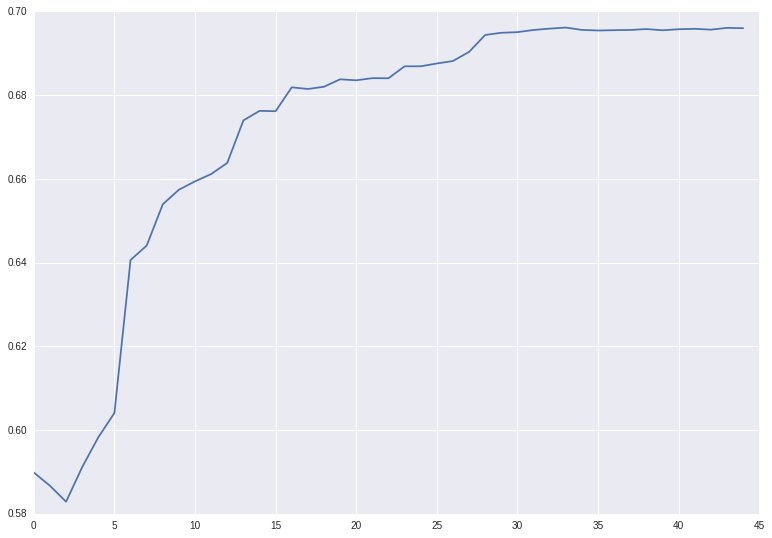

In [5]:
plt.figure(figsize=(13,9))
plt.plot(range(len(selector.grid_scores_)), selector.grid_scores_)

In [4]:
# columns selected for df0_train after RFECV
columns0 = ['APP_NB', 'APP_NB_PAYS', 'APP_NB_TYPE', 'COUNTRY', 'FIRST_CLASSE', 'FISRT_APP_COUNTRY', 
           'FISRT_APP_TYPE', 'FISRT_INV_COUNTRY', 'FISRT_INV_TYPE', 'INV_NB', 'INV_NB_PAYS', 
           'INV_NB_TYPE', 'LANGUAGE_OF_FILLING', 'MAIN_IPC', 'NB_BACKWARD', 'NB_BACKWARD_AUTRE', 
           'NB_BACKWARD_NPL', 'NB_BACKWARD_PL', 'NB_BACKWARD_XY', 'NB_CLASSES', 'NB_FIELDS', 
           'NB_ROOT_CLASSES', 'NB_SECTORS', 'TECHNOLOGIE_FIELD', 'TECHNOLOGIE_SECTOR', 'VOIE_DEPOT', 
           'oecd_NB_BACKWARD_NPL', 'oecd_NB_BACKWARD_PL', 'oecd_NB_ROOT_CLASSES', 'pct_NB_IPC', 'pct_NB_IPC_LY',
           'filing-begin', 'pub-filing', 'pub_year', 'VARIABLE_CIBLE']



df0_train = df0_train[columns0]

df_train0, df_test0 = train_test_split(df0_train, test_size=0.2, random_state=42)

columns0.remove('VARIABLE_CIBLE')
clf0 = RandomForestClassifier(n_estimators=1300, class_weight='balanced', 
                             min_samples_split=1, max_depth=None, n_jobs=6)

clf0.fit(df_train0[columns0].values, df_train0.VARIABLE_CIBLE.values)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=1,
            min_weight_fraction_leaf=0.0, n_estimators=1300, n_jobs=6,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [5]:
Y_proba0 = clf0.predict_proba(df_test0[columns0].values)
roc_auc = roc_auc_score(df_test0.VARIABLE_CIBLE.values, Y_proba0[:,1])

print('score', roc_auc)

score 0.696519799069


# features selection on df1

In [3]:
features = df1.columns.tolist()
features.remove('VARIABLE_CIBLE')
features.remove('index_origin')

# features selection
estimator = RandomForestClassifier(n_estimators=300, n_jobs=6, class_weight='balanced')
selector = RFECV(estimator, step=1, cv=3, scoring='roc_auc', verbose=3)

selector.fit(df1_train[features].values, df1_train['VARIABLE_CIBLE'].values)
cols = [features[i] for i in range(len(features)) if selector.support_[i]]

cols.append('VARIABLE_CIBLE')
print(df1.shape)
df1 = df1[cols]
print(df1.shape)
print( df1.head())

Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 fe

In [4]:
print(cols)

['APP_NB', 'APP_NB_PAYS', 'APP_NB_TYPE', 'COUNTRY', 'FIRST_CLASSE', 'FISRT_APP_COUNTRY', 'FISRT_APP_TYPE', 'FISRT_INV_COUNTRY', 'FISRT_INV_TYPE', 'IDX_ORIGIN', 'IDX_RADIC', 'INV_NB', 'INV_NB_PAYS', 'INV_NB_TYPE', 'LANGUAGE_OF_FILLING', 'MAIN_IPC', 'NB_BACKWARD', 'NB_BACKWARD_AUTRE', 'NB_BACKWARD_NPL', 'NB_BACKWARD_PL', 'NB_BACKWARD_XY', 'NB_CLASSES', 'NB_FIELDS', 'NB_ROOT_CLASSES', 'NB_SECTORS', 'SOURCE_BEGIN_MONTH', 'SOURCE_IDX_RAD', 'TECHNOLOGIE_FIELD', 'TECHNOLOGIE_SECTOR', 'cited_age_max', 'cited_age_mean', 'cited_age_median', 'cited_age_min', 'cited_age_std', 'cited_n', 'oecd_NB_BACKWARD_NPL', 'oecd_NB_BACKWARD_PL', 'oecd_NB_ROOT_CLASSES', 'pct_NB_IPC', 'pct_NB_IPC_LY', 'filing-begin', 'pub-filing', 'pub_year', 'VARIABLE_CIBLE']


In [5]:
columns1 = ['APP_NB', 'APP_NB_PAYS', 'APP_NB_TYPE', 'COUNTRY', 'FIRST_CLASSE', 'FISRT_APP_COUNTRY', 
            'FISRT_APP_TYPE', 'FISRT_INV_COUNTRY', 'FISRT_INV_TYPE', 'IDX_ORIGIN', 'IDX_RADIC', 'INV_NB',
            'INV_NB_PAYS', 'INV_NB_TYPE', 'LANGUAGE_OF_FILLING', 'MAIN_IPC', 'NB_BACKWARD', 'NB_BACKWARD_AUTRE',
            'NB_BACKWARD_NPL', 'NB_BACKWARD_PL', 'NB_BACKWARD_XY', 'NB_CLASSES', 'NB_FIELDS', 'NB_ROOT_CLASSES',
            'NB_SECTORS', 'SOURCE_BEGIN_MONTH', 'SOURCE_IDX_RAD', 'TECHNOLOGIE_FIELD', 'TECHNOLOGIE_SECTOR',
            'cited_age_max', 'cited_age_mean', 'cited_age_median', 'cited_age_min', 'cited_age_std', 'cited_n',
            'oecd_NB_BACKWARD_NPL', 'oecd_NB_BACKWARD_PL', 'oecd_NB_ROOT_CLASSES', 'pct_NB_IPC', 'pct_NB_IPC_LY',
            'filing-begin', 'pub-filing', 'pub_year', 'VARIABLE_CIBLE']


removed = [col for col in df1_train.columns if col not in columns1]
print(removed)

['NB_BACKWARD_I', 'SOURCE_CITED_AGE', 'SOURCE_IDX_ORI', 'VOIE_DEPOT', 'index_origin']


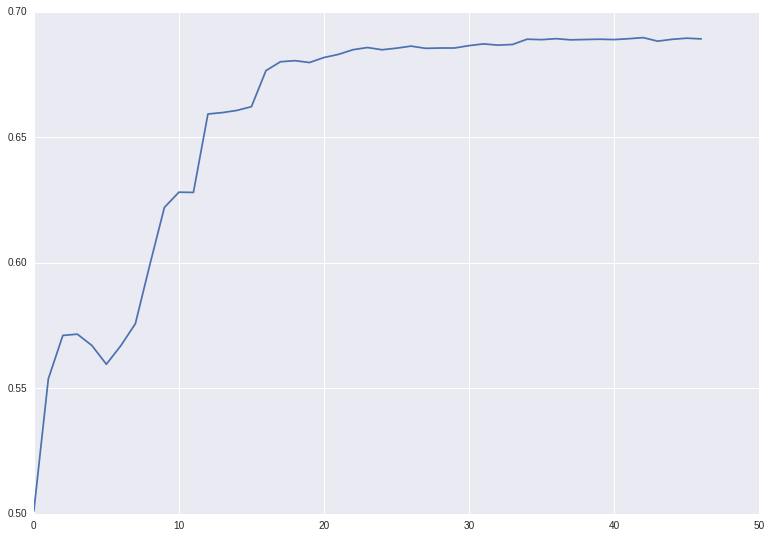

In [6]:
plt.figure(figsize=(13,9))
plt.plot(range(len(selector.grid_scores_)), selector.grid_scores_)

# xgboost

### training on df0

In [3]:
# columns selected for df0_train after RFECV
columns0 = ['APP_NB', 'APP_NB_PAYS', 'APP_NB_TYPE', 'COUNTRY', 'FIRST_CLASSE', 'FISRT_APP_COUNTRY', 
           'FISRT_APP_TYPE', 'FISRT_INV_COUNTRY', 'FISRT_INV_TYPE', 'INV_NB', 'INV_NB_PAYS', 
           'INV_NB_TYPE', 'LANGUAGE_OF_FILLING', 'MAIN_IPC', 'NB_BACKWARD', 'NB_BACKWARD_AUTRE', 
           'NB_BACKWARD_NPL', 'NB_BACKWARD_PL', 'NB_BACKWARD_XY', 'NB_CLASSES', 'NB_FIELDS', 
           'NB_ROOT_CLASSES', 'NB_SECTORS', 'TECHNOLOGIE_FIELD', 'TECHNOLOGIE_SECTOR', 'VOIE_DEPOT', 
           'oecd_NB_BACKWARD_NPL', 'oecd_NB_BACKWARD_PL', 'oecd_NB_ROOT_CLASSES', 'pct_NB_IPC', 'pct_NB_IPC_LY',
           'filing-begin', 'pub-filing', 'pub_year', 'VARIABLE_CIBLE']

removed = [col for col in df0_train.columns if col not in columns0]
print(removed)

df_train0, df_test0 = train_test_split(df0_train[columns0], test_size=0.2, random_state=42)

columns0.remove('VARIABLE_CIBLE')


['IDX_ORIGIN', 'IDX_RADIC', 'NB_BACKWARD_I', 'SOURCE_BEGIN_MONTH', 'SOURCE_CITED_AGE', 'SOURCE_IDX_ORI', 'SOURCE_IDX_RAD', 'cited_age_max', 'cited_age_mean', 'cited_age_median', 'cited_age_min', 'index_origin']


In [4]:
test_size = len(df_test0)
train_size = len(df_train0)
# rescale weight to make it same as test set
weight = np.ones(train_size) * float(test_size) / float(train_size)

print(df_train0.columns)

sum_wpos = sum( weight[i] for i in range(train_size) if df_train0['VARIABLE_CIBLE'].iloc[i] == 1.0  )
sum_wneg = sum( weight[i] for i in range(train_size) if df_train0['VARIABLE_CIBLE'].iloc[i] == 0.0  )

# print weight statistics
print ('weight statistics: wpos=%g, wneg=%g, ratio=%g' % ( sum_wpos, sum_wneg, sum_wneg/sum_wpos ))


# construct xgboost.DMatrix from numpy array, treat -999.0 as missing value
dtrain0 = xgb.DMatrix( df_train0[columns0].values, label=df_train0['VARIABLE_CIBLE'].values, weight=weight )
dtest0 = xgb.DMatrix( df_test0[columns0].values, label=df_test0['VARIABLE_CIBLE'].values)

# setup parameters for xgboost
param = {}
# use logistic regression loss, use raw prediction before logistic transformation
# since we only need the rank
param['objective'] = 'binary:logistic'
# scale weight of positive examples
param['scale_pos_weight'] = sum_wneg/sum_wpos
param['eta'] = 0.3
param['max_depth'] = 6
param['eval_metric'] = 'auc'
param['silent'] = 0
param['nthread'] = 6

# you can directly throw param in, though we want to watch multiple metrics here
plst = list(param.items())


evallist  = [(dtrain0,'train'), (dtest0,'eval')]



num_round = 127
print ('loading data end, start to boost trees')
bst0 = xgb.train( plst, dtrain0, num_round, evallist)#, early_stopping_rounds=50 );
# save out model
bst0.save_model('df0_rfecv.model')

print ('finish training')


Index(['APP_NB', 'APP_NB_PAYS', 'APP_NB_TYPE', 'COUNTRY', 'FIRST_CLASSE',
       'FISRT_APP_COUNTRY', 'FISRT_APP_TYPE', 'FISRT_INV_COUNTRY',
       'FISRT_INV_TYPE', 'INV_NB', 'INV_NB_PAYS', 'INV_NB_TYPE',
       'LANGUAGE_OF_FILLING', 'MAIN_IPC', 'NB_BACKWARD', 'NB_BACKWARD_AUTRE',
       'NB_BACKWARD_NPL', 'NB_BACKWARD_PL', 'NB_BACKWARD_XY', 'NB_CLASSES',
       'NB_FIELDS', 'NB_ROOT_CLASSES', 'NB_SECTORS', 'TECHNOLOGIE_FIELD',
       'TECHNOLOGIE_SECTOR', 'VOIE_DEPOT', 'oecd_NB_BACKWARD_NPL',
       'oecd_NB_BACKWARD_PL', 'oecd_NB_ROOT_CLASSES', 'pct_NB_IPC',
       'pct_NB_IPC_LY', 'filing-begin', 'pub-filing', 'pub_year',
       'VARIABLE_CIBLE'],
      dtype='object')
weight statistics: wpos=14415.8, wneg=19123.2, ratio=1.32654
loading data end, start to boost trees

[0]	train-auc:0.661165
[1]	train-auc:0.669866
[2]	train-auc:0.678096
[3]	train-auc:0.684199
[4]	train-auc:0.688666
[5]	train-auc:0.692645
[6]	train-auc:0.696437
[7]	train-auc:0.700498
[8]	train-auc:0.703279
[9]	train-auc:0.705570
[10]	train-auc:0.706984
[11]	train-auc:0.708640
[12]	train-auc:0.709729
[13]	train-auc:0.711538
[14]	train-auc:0.712656
[15]	train-auc:0.714327
[16]	train-auc:0.716169
[17]	train-auc:0.717288
[18]	train-auc:0.718185
[19]	train-auc:0.719423
[20]	train-auc:0.720649
[21]	train-auc:0.721332
[22]	train-auc:0.723163
[23]	train-auc:0.724274
[24]	train-auc:0.725077
[25]	train-auc:0.726321
[26]	train-auc:0.726557
[27]	train-auc:0.726933
[28]	train-auc:0.727092
[29]	train-auc:0.727864
[30]	train-auc:0.728787
[31]	train-auc:0.729961
[32]	train-auc:0.730796
[33]	train-auc:0.731033
[34]	train-auc:0.731356
[35]	train-auc:0.731990
[36]	train-auc:0.732637
[37]	train-auc:0.733088
[38]	train-auc:0.733539
[39]	train-auc:0.734351
[40]	train-auc:0.735559
[41]	train-auc:0.736652
[4


finish training


[126]	train-auc:0.775874


In [36]:
print('best n_tree limit :', bst0.best_ntree_limit)
print('best iteration :', bst0.best_iteration)

best n_tree limit : 128
best iteration : 127


best n_tree limit : 70

best iteration : 69

### training on df1

In [5]:
columns1 = ['APP_NB', 'APP_NB_PAYS', 'APP_NB_TYPE', 'COUNTRY', 'FIRST_CLASSE', 'FISRT_APP_COUNTRY', 
            'FISRT_APP_TYPE', 'FISRT_INV_COUNTRY', 'FISRT_INV_TYPE', 'IDX_ORIGIN', 'IDX_RADIC', 'INV_NB',
            'INV_NB_PAYS', 'INV_NB_TYPE', 'LANGUAGE_OF_FILLING', 'MAIN_IPC', 'NB_BACKWARD', 'NB_BACKWARD_AUTRE',
            'NB_BACKWARD_NPL', 'NB_BACKWARD_PL', 'NB_BACKWARD_XY', 'NB_CLASSES', 'NB_FIELDS', 'NB_ROOT_CLASSES',
            'NB_SECTORS', 'SOURCE_BEGIN_MONTH', 'SOURCE_IDX_RAD', 'TECHNOLOGIE_FIELD', 'TECHNOLOGIE_SECTOR',
            'cited_age_max', 'cited_age_mean', 'cited_age_median', 'cited_age_min', 'cited_age_std', 'cited_n',
            'oecd_NB_BACKWARD_NPL', 'oecd_NB_BACKWARD_PL', 'oecd_NB_ROOT_CLASSES', 'pct_NB_IPC', 'pct_NB_IPC_LY',
            'filing-begin', 'pub-filing', 'pub_year', 'VARIABLE_CIBLE']

df_train1, df_test1 = train_test_split(df1_train[columns1], test_size=0.2, random_state=42)

columns1.remove('VARIABLE_CIBLE')

In [6]:
test_size = len(df_test1)
train_size = len(df_train1)
# rescale weight to make it same as test set
weight = np.ones(train_size) * float(test_size) / float(train_size)


sum_wpos = sum( weight[i] for i in range(train_size) if df_train1['VARIABLE_CIBLE'].iloc[i] == 1.0  )
sum_wneg = sum( weight[i] for i in range(train_size) if df_train1['VARIABLE_CIBLE'].iloc[i] == 0.0  )

# print weight statistics
print ('weight statistics: wpos=%g, wneg=%g, ratio=%g' % ( sum_wpos, sum_wneg, sum_wneg/sum_wpos ))


# construct xgboost.DMatrix from numpy array, treat -999.0 as missing value
dtrain1 = xgb.DMatrix( df_train1[columns1].values, label=df_train1['VARIABLE_CIBLE'].values, weight=weight )
dtest1 = xgb.DMatrix( df_test1[columns1].values, label=df_test1['VARIABLE_CIBLE'].values)

# setup parameters for xgboost
param = {}
# use logistic regression loss, use raw prediction before logistic transformation
# since we only need the rank
param['objective'] = 'binary:logistic'
# scale weight of positive examples
param['scale_pos_weight'] = sum_wneg/sum_wpos
param['eta'] = 0.3
param['max_depth'] = 4
param['eval_metric'] = 'auc'
param['silent'] = 0
param['nthread'] = 6

# you can directly throw param in, though we want to watch multiple metrics here
plst = list(param.items())


evallist  = [(dtrain1,'train'), (dtest1,'eval')]


# boost 120 tres
num_round = 143
print ('loading data end, start to boost trees')
bst1 = xgb.train( plst, dtrain1, num_round, evallist)#,early_stopping_rounds=50 );
# save out model
bst1.save_model('df1_rfecv.model')

print ('finish training')

weight statistics: wpos=7066.1, wneg=11281.9, ratio=1.59662
loading data end, start to boost trees

[0]	train-auc:0.653260
[1]	train-auc:0.662263
[2]	train-auc:0.666141
[3]	train-auc:0.671018
[4]	train-auc:0.673712
[5]	train-auc:0.678009
[6]	train-auc:0.680689
[7]	train-auc:0.683003
[8]	train-auc:0.685821
[9]	train-auc:0.687769
[10]	train-auc:0.689692
[11]	train-auc:0.691520
[12]	train-auc:0.693819
[13]	train-auc:0.694903
[14]	train-auc:0.696397
[15]	train-auc:0.697781
[16]	train-auc:0.698994
[17]	train-auc:0.699697
[18]	train-auc:0.700517
[19]	train-auc:0.701811
[20]	train-auc:0.702885
[21]	train-auc:0.703989
[22]	train-auc:0.705037
[23]	train-auc:0.705673
[24]	train-auc:0.706396
[25]	train-auc:0.707328
[26]	train-auc:0.708196
[27]	train-auc:0.708847
[28]	train-auc:0.709859
[29]	train-auc:0.710549
[30]	train-auc:0.711023
[31]	train-auc:0.711693
[32]	train-auc:0.712088
[33]	train-auc:0.713113
[34]	train-auc:0.713462
[35]	train-auc:0.713867
[36]	train-auc:0.714365
[37]	train-auc:0.715058
[38]	train-auc:0.715448
[39]	train-auc:0.715676
[40]	train-auc:0.716079
[41]	train-auc:0.716527
[4


finish training


[142]	train-auc:0.759305


In [38]:
print('best n_tree limit :', bst1.best_ntree_limit)
print('best iteration :', bst1.best_iteration)

best n_tree limit : 144
best iteration : 143


best n_tree limit : 144

best iteration : 143

# Combining models on df1 and df0

In [7]:
deval0 = xgb.DMatrix(df0_eval[columns0].values)
y0 = bst0.predict(deval0)

deval1 = xgb.DMatrix(df1_eval[columns1].values)
y1 = bst1.predict(deval1)


df0_eval['proba_c0'] = y0
df0_eval['proba_c1'] = 1 - y0 

df1_eval['proba_c0'] = y1 
df1_eval['proba_c1'] = 1 - y1 

cols = ['proba_c0', 'proba_c1', 'index_origin']

df_eval_res = pd.concat((df0_eval[cols], df1_eval[cols]), axis=0, ignore_index=True)

print(y0)
print(y1)

df_eval_res.head()

[ 0.59825236  0.32929999  0.77510118 ...,  0.67339784  0.54275352
  0.52737063]
[ 0.72158355  0.68395007  0.56873339 ...,  0.63335812  0.67596596
  0.78151017]


,proba_c0,proba_c1,index_origin
0,0.598252,0.401748,1
1,0.329300,0.670700,2
2,0.775101,0.224899,3
3,0.274956,0.725044,4
4,0.144969,0.855031,7


In [8]:
df_eval_res = df_eval_res.sort_index(by='index_origin', ascending=True)

df_eval_res.head()

/home/maxime/local/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  if __name__ == '__main__':


,proba_c0,proba_c1,index_origin
84092,0.721584,0.278416,0
0,0.598252,0.401748,1
1,0.329300,0.670700,2
2,0.775101,0.224899,3
3,0.274956,0.725044,4


In [9]:
np.savetxt('y_pred_xgboost.txt', df_eval_res['proba_c1'].values, fmt='%s')